In [55]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from importlib import reload
import src.cathay_db as db
import src.utils as ut
import src.financial_statement as fs

reload(ut)
reload(fs)
import matplotlib.pyplot as plt
import datetime
import os
import xgboost as xgb
sys.path.append("./src")

from toolbox import print_progress_bar

# set max display rows
pd.set_option("display.max_rows", 200)

# set max display columns
pd.set_option("display.max_columns", 100)

# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format

In [56]:
df_price = pd.read_feather('data/cmoney_price.feather')
df_price = ut.cmoney_data_clean_up(df_price)
df_price = df_price[['日期','股票代號','收盤價']]
df_price.columns = ['date','ticker','unadj_price']
df_price['date'] = pd.to_datetime(df_price['date'])
# sort by date for shift
df_price.sort_values(['ticker','date'],inplace=True)
# shift to get last day price
df_price['yesterday_price'] = df_price.groupby('ticker')['unadj_price'].shift(1)
df_price['unadj_price'] = df_price['unadj_price'].astype(float)
df_price['yesterday_price'] = df_price['yesterday_price'].astype(float)

In [57]:
# select model 
model_folder_name = '20230719_083148'
# model_folder_name = '20230712_173216'
# model_folder_name = '20230712_173216'
# model_folder_name = '20230711_171428'
# model_folder_name = '20230711_110457'
# model_folder_name = '20230707_140403'
# model_folder_name = '20230706_141045'

apply_buffer_index = 0
base_portfolio_number = 50
buffer_portfolio_number = 150

# model_folder_name = '20230706_141045'

# load setting from data/model/model_folder_name/setting.json
setting = ut.load_json(f'./data/model/{model_folder_name}/setting.json')

print(setting.keys())
print(setting['factor_columns'])

apply_restrict_index = 1
base_portfolio_number = 50
restrict_portfolio_number = 60

# df_dividend_select.to_feather(f'./data/model/{model_folder_name}/df_dividend_select.feather')
# df_dividend_select = pd.read_feather(f'./data/model/{model_folder_name}/df_dividend_select.feather')
# df_dividend_select = pd.read_feather(f'./data/model/{model_folder_name}/df_buffer_result_{apply_buffer_index}_{base_portfolio_number}_{buffer_portfolio_number}.feather')
df_dividend_select = pd.read_feather(f'./data/model/{model_folder_name}/df_restrict_result_{apply_restrict_index}_{base_portfolio_number}_{restrict_portfolio_number}.feather')
# df_select_filter_dividends_yield_top_50.to_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_top_50.feather')
# df_dividend_select = pd.read_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_top_50.feather')
# df_dividend_select_benchmark = pd.read_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_benchmark.feather')

# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')

select_ticker = df_dividend_select['ticker'].unique()

df_cash_dividends = pd.read_feather('data/tej_cash_dividends.feather')
df_cash_dividends = ut.tej_data_clean_up(df_cash_dividends)
df_cash_dividends = df_cash_dividends[['股票代號','除息日','息值(元)']].copy()
df_cash_dividends.columns = ['ticker','date','dividend']
df_cash_dividends = df_cash_dividends[df_cash_dividends['ticker'].isin(select_ticker)].copy()
df_cash_dividends.drop_duplicates(inplace=True)
df_cash_dividends['dividend'] = df_cash_dividends['dividend'].astype(float)
df_cash_dividends = df_cash_dividends.groupby(['ticker','date']).sum().reset_index()

dict_keys(['start_index', 'rebalance_date_lst', 'factor_columns', 'target_cols', 'model_save_path', 'param_search', 'fit_params'])
['asset_qoq', 'asset_yoy', 'ni_qoq', 'ni_yoy', 'roe', 'roe_yoy', 'roe_4q_sum', 'roe_4q_sum_yoy', 'tobins_q', 'ocf / asset', '20_d_return', '40_d_return', '60_d_return', 'dividend_1Y_sum_yield', 'dividend_2Y_sum_yield', 'dividend_3Y_sum_yield', 'last_dividend_yield']


In [58]:
df_dividend_select

,date,ticker,price,excess_return,asset_qoq,asset_yoy,ppe_qoq,ppe_yoy,ni_qoq,ni_yoy,roe,roe_yoy,roe_4q_sum,roe_4q_sum_yoy,tobins_q,ocf / asset,20_d_return,40_d_return,60_d_return,dividend_1Y_sum_yield,dividend_2Y_sum_yield,dividend_3Y_sum_yield,last_dividend_yield,price_62d,y,y_std,y_mean,upper,lower,y_truncated,y_norm_truncated,y_rank,sample_weight,rebalance_date,model_path,predict,predict_rank,market_cap,market_cap_rank,flag_all
0,2005-03-15,2417,12.9860,0.0484,1.2418,1.2418,1.2252,1.2252,1.3878,1.3878,0.8858,0.2417,0.2214,0.2417,1.4338,0.1622,0.0492,0.1268,0.1429,0.0476,0.0724,0.0883,0.0000,12.6816,-0.0234,0.1922,-0.0236,0.9375,-0.9847,-0.0234,0.0034,0.4307,1,2005-03-15,./models/20230719_083148/20050315.json,0.3614,11.0000,4246416.0000,271.0000,0
1,2005-03-15,2308,20.1851,-0.0600,1.0260,1.0260,0.9896,0.9896,1.2773,1.2773,0.7423,0.2458,0.1856,0.2458,1.4047,0.1240,-0.0593,-0.0231,-0.0505,0.0443,0.0837,0.1083,0.0000,20.5427,0.0177,0.1922,-0.0236,0.9375,-0.9847,0.0177,0.2205,0.3127,1,2005-03-15,./models/20230719_083148/20050315.json,0.2912,16.5000,80567377.6000,23.0000,0
2,2005-03-15,9910,7.6709,-0.0008,1.0589,1.0589,1.0275,1.0275,1.0611,1.0611,0.4177,0.0379,0.1044,0.0379,0.9976,0.2038,0.0000,-0.0057,-0.0028,0.0455,0.1080,0.1364,0.0000,7.6818,0.0014,0.1922,-0.0236,0.9375,-0.9847,0.0014,0.1345,0.3618,1,2005-03-15,./models/20230719_083148/20050315.json,0.2912,16.5000,14585042.5600,103.0000,0
3,2005-03-15,2015,11.3835,-0.0348,1.3433,1.3433,1.1042,1.1042,2.9867,2.9867,1.4135,1.1782,0.3534,1.1782,1.4583,0.1447,-0.0341,0.0232,0.0312,0.0403,0.0655,0.0730,0.0000,8.9176,-0.2166,0.1922,-0.0236,0.9375,-0.9847,-0.2166,-1.0154,0.9147,3,2005-03-15,./models/20230719_083148/20050315.json,0.2912,16.5000,20836826.8700,79.0000,0
4,2005-03-15,3045,16.3996,0.0222,0.8892,0.8892,0.9472,0.9472,1.2483,1.2483,0.8071,0.1498,0.2018,0.1498,1.5572,0.2427,0.0229,-0.0360,-0.0360,0.0710,0.1308,0.1876,0.0000,15.5662,-0.0508,0.1922,-0.0236,0.9375,-0.9847,-0.0508,-0.1410,0.5228,1,2005-03-15,./models/20230719_083148/20050315.json,0.2912,16.5000,164443424.5800,12.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2022-12-15,4736,177.0000,-0.0439,0.9022,1.1678,1.0628,1.1526,0.5130,1.3680,0.3383,1.2807,0.3450,0.3335,1.4097,0.2187,-0.0432,0.0412,0.0261,0.0844,0.1490,0.1853,0.0000,185.5000,0.0480,0.1733,0.0901,0.9565,-0.7763,0.0480,-0.2495,0.5253,1,2022-12-15,./models/20230719_083148/20221215.json,0.2595,99.0000,16822929.6000,289.0000,0
3596,2022-12-15,5483,155.3600,-0.0223,1.0155,1.1894,1.0218,1.1875,1.6994,1.6927,0.1907,0.7721,0.1168,-0.1053,0.7932,0.1466,-0.0216,0.3045,0.0096,0.0486,0.1274,0.1590,0.0202,154.0000,-0.0088,0.1733,0.0901,0.9565,-0.7763,-0.0088,-0.6004,0.7736,1,2022-12-15,./models/20230719_083148/20221215.json,0.3463,5.0000,92916139.4500,68.0000,0
3597,2022-12-15,6269,102.5000,-0.0516,1.1145,1.0638,0.9901,1.1807,6.6083,2.0366,0.3111,0.5257,0.1749,0.5604,0.8468,0.2060,-0.0509,0.1491,0.0688,0.0488,0.0987,0.1472,0.0000,98.4000,-0.0400,0.1733,0.0901,0.9565,-0.7763,-0.0400,-0.7935,0.8663,3,2022-12-15,./models/20230719_083148/20221215.json,0.2864,37.0000,33088066.0000,152.0000,0
3598,2022-12-15,6412,69.9474,0.0659,1.0176,1.0475,1.0199,1.1237,1.2517,1.1784,0.3208,0.1603,0.2708,0.0647,1.0788,0.0873,0.0666,0.0189,0.0977,0.0691,0.1222,0.1647,0.0000,77.1000,0.1023,0.1733,0.0901,0.9565,-0.7763,0.1023,0.0857,0.3309,1,2022-12-15,./models/20230719_083148/20221215.json,0.2612,95.0000,29772746.5200,169.0000,0


# 計算持有期間取得的現金股利率

In [59]:
df_factor_all_price = pd.merge(df_factor_all,df_price,on=['date','ticker'],how='left')

df_factor_all_price_dividend = pd.merge(df_factor_all_price,df_cash_dividends,on=['date','ticker'],how='left')
df_factor_all_price_dividend['unadj_yield'] = df_factor_all_price_dividend['dividend'] / df_factor_all_price_dividend['yesterday_price']

# calculate the sum of dividend yield of each stock in each period 
df_period_yield = df_factor_all_price_dividend.groupby(['ticker','rebalance_date'], as_index=False, group_keys=False)['unadj_yield'].sum()

# merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
df_dividend_select_yield = pd.merge(df_dividend_select,df_period_yield,on=['ticker','rebalance_date'],how='left')

df_quaterly_div = df_dividend_select_yield.groupby('rebalance_date')['unadj_yield'].mean().reset_index()
df_quaterly_div['year'] = df_quaterly_div['rebalance_date'].dt.year
df_quaterly_div.groupby('year')['unadj_yield'].sum().reset_index()['unadj_yield'].describe().reset_index()

,index,unadj_yield
0,count,18.0000
1,mean,0.0569
2,std,0.0085
3,min,0.0410
4,25%,0.0525
5,50%,0.0563
6,75%,0.0593
7,max,0.0756


<Axes: xlabel='year'>

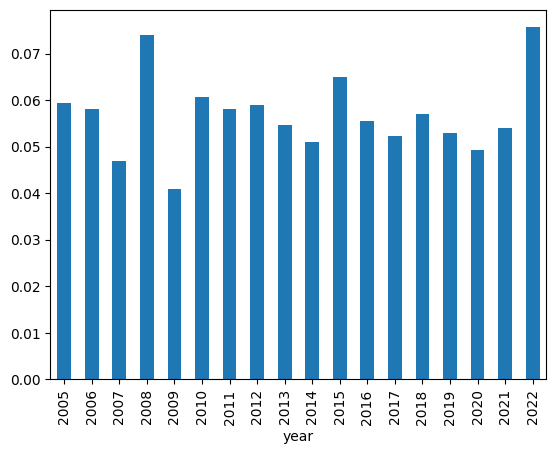

In [60]:
df_quaterly_div.groupby('year')['unadj_yield'].sum().plot(kind='bar')

# 計算選股 pct_rank 統計資料

In [61]:
# create pct_rank for y by date
df_factor_all['y_pct_rank'] = df_factor_all.groupby('date')['y'].rank(pct=True, ascending=True)
df_dividend_select = df_dividend_select.merge(df_factor_all[['ticker','date','y_pct_rank']],on=['ticker','date'],how='left')
df_dividend_select.groupby('date')['y_pct_rank'].describe().mean().reset_index()

,index,0
0,count,50.0000
1,mean,0.5378
2,std,0.2417
3,min,0.0639
4,25%,0.3580
5,50%,0.5531
6,75%,0.7281
7,max,0.9476


# 計算持有期間換倉的周轉率

In [75]:
# create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

df_weight = pd.pivot(df_dividend_select_yield, index='rebalance_date', columns='ticker', values='weight').copy()
df_weight.fillna(0,inplace=True)

# calculate the turnover by calculate the abs change of weight and sum up
df_weight_change = df_weight.diff().abs() / 2 * 100
df_quarterly_turnover = df_weight_change.sum(axis=1).reset_index()
df_quarterly_turnover.columns = ['rebalance_date','turnover']

df_quarterly_turnover['year'] = df_quarterly_turnover['rebalance_date'].dt.year
df_quarterly_turnover['quarter'] = df_quarterly_turnover['rebalance_date'].dt.quarter
df_yearly_turnover = df_quarterly_turnover.groupby('year')['turnover'].sum().reset_index()
# df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
df_yearly_turnover['turnover'].describe().reset_index()

,index,turnover
0,count,18.0000
1,mean,85.0000
2,std,11.2981
3,min,62.0000
4,25%,80.0000
5,50%,84.0000
6,75%,88.0000
7,max,122.0000
